# **`FER Model`**

## Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from keras import regularizers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD, Adamax
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

2024-01-25 18:12:54.621456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = '../fer_dataset/train/'
test_dir = '../fer_dataset/test/'

In [3]:
def count_expressions(path, set):
    dict = {}
    for expression in os.listdir(path):
        dir = os.path.join(path, expression)
        dict[expression] = len(os.listdir(dir))
    
    df = pd.DataFrame(dict, index=[set])
    return df

train_df = count_expressions(train_dir, 'train')
test_df = count_expressions(test_dir, 'test')

print(train_df, '\n')
print(test_df)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436 

      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


As we can see above we got training and testing data with number of images in each classes that are ***happy, sad, fear, surprise, neutral, angry, disgust***.

<Axes: >

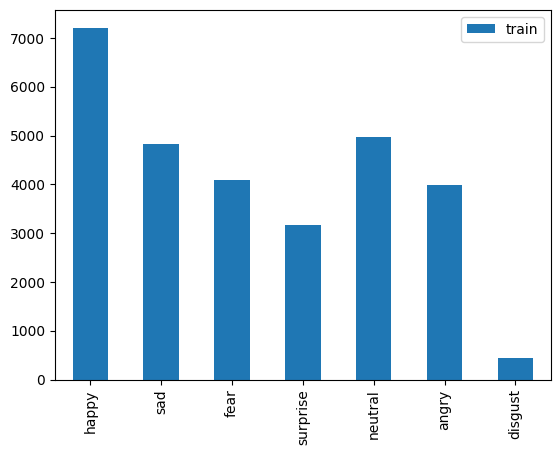

In [4]:
train_df.transpose().plot(kind='bar')

<Axes: >

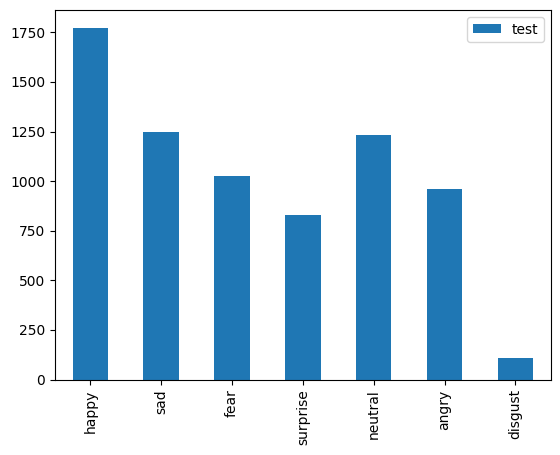

In [5]:
test_df.transpose().plot(kind='bar')

As we can see above the class with least images is ***disgust***

../fer_dataset/train/ + happy/Training_70433018.jpg
../fer_dataset/train/ + sad/Training_54521994.jpg
../fer_dataset/train/ + fear/Training_84637793.jpg
../fer_dataset/train/ + surprise/Training_63289181.jpg
../fer_dataset/train/ + neutral/Training_22310147.jpg
../fer_dataset/train/ + angry/Training_92439792.jpg
../fer_dataset/train/ + disgust/Training_76673939.jpg


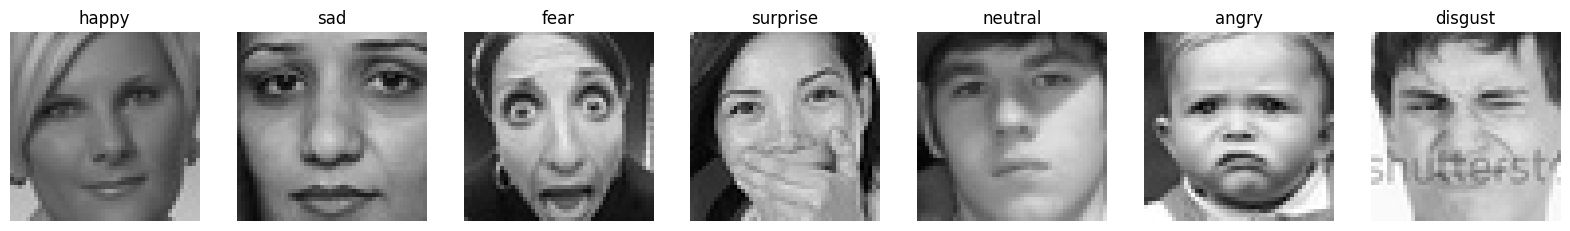

In [6]:
plt.figure(figsize=(20, 20))
i = 1
for expression in os.listdir(train_dir):
    print(f"{train_dir} + {expression}/{os.listdir(train_dir + expression)[1]}")
    img = load_img((train_dir + expression + '/' + os.listdir(train_dir + expression)[1]))
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range= 30,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    horizontal_flip= True,
    rescale= 1./255,
    fill_mode= 'nearest',
    # zoom_range= 0.2,
    # validation_split= 0.2
)

validation_datagen = ImageDataGenerator(
    rescale= 1./255,
    # validation_split= 0.2,
)

In [8]:
img_size = 48

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size= 64,
    color_mode='grayscale',
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size= 64,
    color_mode='grayscale',
    class_mode='categorical',
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


There are ***28709*** images from 7 classes in the train directory and ***7178*** images in the test directory

## Model

In [9]:
model = Sequential()

# Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48,48,1))) # Input
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Block 2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2()))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2()))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Block 3
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2()))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2()))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Block 4
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2()))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2()))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=7, activation='softmax')) # Output

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 9675719 (36.91 MB)
Trainable params: 9671879 (36.90 MB)
Non-trainable params: 3840 (15.00 KB)
_________________________________________________________________


In [12]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-10),
             EarlyStopping(monitor='val_loss', patience=15)]

In [13]:
batch_size = 64
epochs = 100

history = model.fit(x=train_generator, batch_size=batch_size, epochs=epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
449/449 [==============================] - 1447s 3s/step - loss: 16.3734 - accuracy: 0.2055 - val_loss: 15.2784 - val_accuracy: 0.2221 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - 1236s 3s/step - loss: 14.2013 - accuracy: 0.2311 - val_loss: 13.0960 - val_accuracy: 0.2354 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - 1181s 3s/step - loss: 11.9767 - accuracy: 0.2395 - val_loss: 10.9068 - val_accuracy: 0.2487 - lr: 1.0000e-04
Epoch 4/100
449/449 [==============================] - 1169s 3s/step - loss: 9.8182 - accuracy: 0.2503 - val_loss: 8.8888 - val_accuracy: 0.2526 - lr: 1.0000e-04
Epoch 5/100
449/449 [==============================] - 1180s 3s/step - loss: 7.8837 - accuracy: 0.2700 - val_loss: 7.2412 - val_accuracy: 0.2627 - lr: 1.0000e-04
Epoch 6/100
449/449 [==============================] - 1171s 3s/step - loss: 6.2694 - accuracy: 0.2853 - val_loss: 5.7443 - val_accuracy: 0.2576 - lr: 1.0000e-04
Epoch 7/100
449/449 [=

`It took 2208 minutes which is 36 hours to train the model for 100 Epochs`

## Evaluation

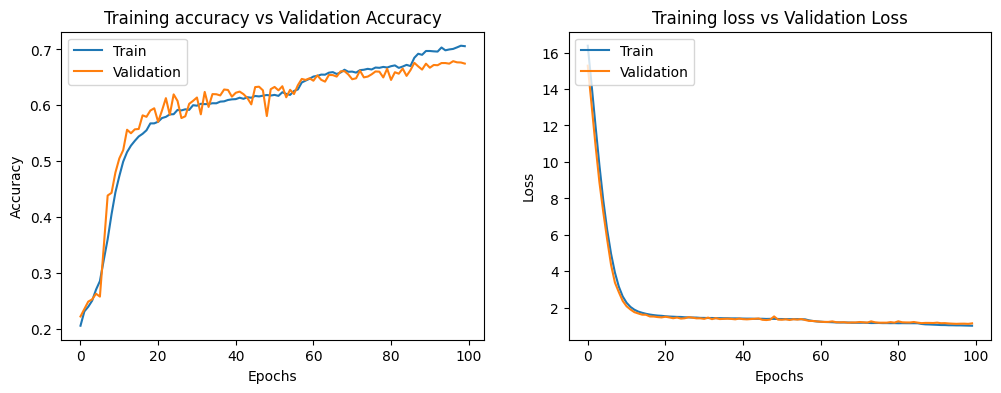

In [18]:
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12, 4)

# Accuracy Plot
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.savefig('training.jpg')
plt.show()

In [19]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(validation_generator)

print("Final train accuracy = {:.2f}, validation accuracy = {:.2f}".format(train_acc * 100, test_acc * 100))

113/113 [==============================] - 70s 620ms/step - loss: 1.1457 - accuracy: 0.6747
Final train accuracy = 74.74, validation accuracy = 67.47


## Confusion Matrix

In [20]:
predictions = model.predict(validation_generator)

113/113 [==============================] - 115s 1s/step


In [21]:
label_dict = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Neutral', 4:'Sad', 5: 'Disgust', 6: 'Surprise'}

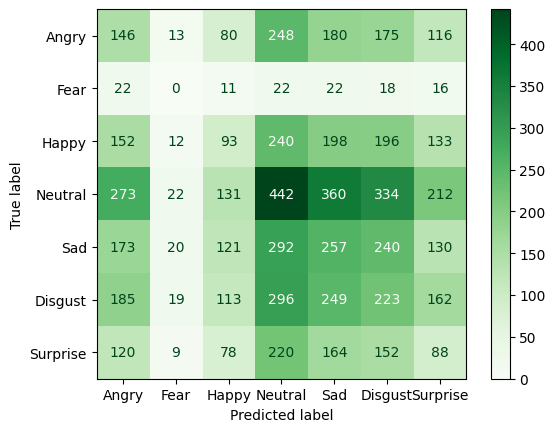

In [37]:
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
#print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=label_dict.values())
cm_display.plot(cmap=plt.cm.Greens,xticks_rotation="horizontal")
plt.show()

## Testing

(48, 48)


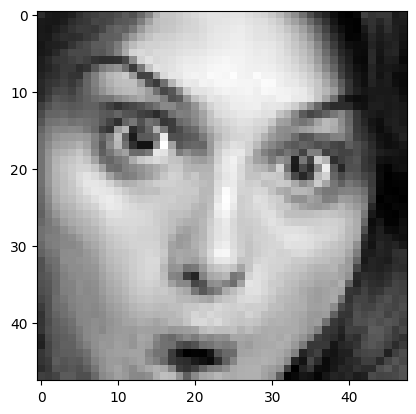

In [33]:
img = cv2.imread("../fer_dataset/train/surprise/Training_8796.jpg",0)
plt.imshow(img, 'gray')
print(img.shape)

(48, 48)


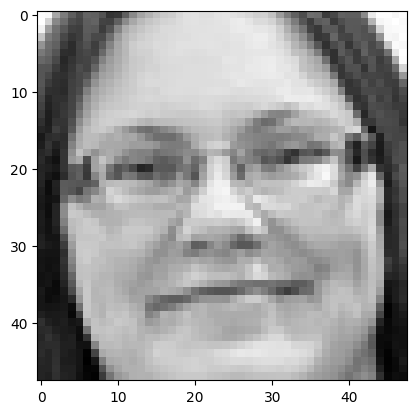

In [34]:
img = cv2.imread("../fer_dataset/train/happy/Training_1206.jpg",0)
plt.imshow(img, 'gray')
print(img.shape)

## Saving the Model

In [36]:
model.save('fer_model.h5')
# Saving model as JSON
model_json = model.to_json()
with open("fer_model.json", "w") as json_file:
    json_file.write(model_json)